In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from astropy import cosmology
from astropy import stats
import matplotlib.pyplot as plt
import getdist as gd
from getdist import MCSamples
import getdist.plots as gdplot
import matplotlib
from scipy.stats import norm
import matplotlib.mlab as mlab
from autogalaxy.util import cosmology_util
import math

cosmo = cosmology.Planck15
fig_path = '/Users/dgmt59/Documents/Plots/full_sample/power_law_analysis/'

In [2]:
from autoconf import conf
import autofit as af
import autolens as al
import autolens.plot as aplt
from collections import Counter

%matplotlib inline
plt.style.use({'figure.facecolor':'white'})

workspace_path = "/Users/dgmt59/PycharmProjects/autolens_slacs/"
output_path = "/Users/dgmt59/output"
aggregator_results_path_1 = output_path + "/slacs_shu_bspline_clean/"

agg = af.Aggregator(directory=str(aggregator_results_path_1), completed_only=True)

Aggregator loading phases... could take some time.

 A total of 468 phases and results were found.


In [3]:
agg_shear_cap = agg.filter(agg.directory.contains("phase[1]_mass[total]_source"),
                           agg.directory.contains("power_law__with_shear"), 
                               agg.directory.contains("stochastic"))

Filter found a total of 36 results


In [4]:
slope_slacs = [info["slope"] for info in agg_shear_cap.values("info")]
instances_shear = [samps.median_pdf_instance for samps in agg_shear_cap.values("samples")]
slopes_shear = [instance.galaxies.lens.mass.slope for instance in instances_shear]

slopes_shear_no_nan = []
slopes_slacs_no_nan = []
for i in  range(len(slope_slacs)):
    if math.isnan(slope_slacs[i]) == False:
        slopes_shear_no_nan.append(slopes_shear[i])
        slopes_slacs_no_nan.append(slope_slacs[i])
    
corr_shear = stats.biweight_midcorrelation(slopes_slacs_no_nan, slopes_shear_no_nan)
print(corr_shear)
bicov = stats.biweight_midcovariance([slopes_slacs_no_nan, slopes_shear_no_nan])
print(bicov) 

0.5206435372608383
[[0.05388451 0.0442901 ]
 [0.0442901  0.13429765]]


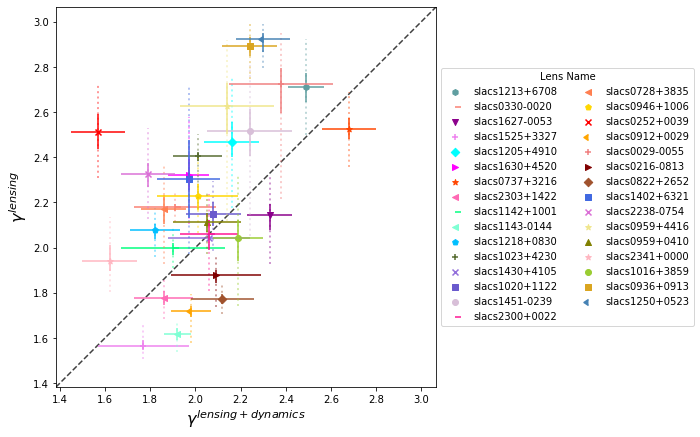

In [5]:
datasets_shear = agg_shear_cap.values("dataset")
info_gen_shear = agg_shear_cap.values("info")
info_shear =[info for info in info_gen_shear]
instances_shear = [samps.median_pdf_instance for samps in agg_shear_cap.values("samples")]

fig1, ax = plt.subplots(figsize=(10,7))
for samps, info, instance, dataset in zip(agg_shear_cap.values("samples"), info_shear, instances_shear, agg_shear_cap.values("dataset")):
    if math.isnan(info['slope']) == False:
        ax.scatter(info['slope'], instance.galaxies.lens.mass.slope,
              color=info['colour'], marker=info['marker'], label=dataset.name)
        ax.errorbar(info['slope'], instance.galaxies.lens.mass.slope,
                    yerr=[[samps.error_vector_at_lower_sigma(sigma=1.0)[7]], [samps.error_vector_at_upper_sigma(sigma=1.0)[7]]],
                    xerr=info['slope_err'], color=info['colour'])
        error_2 = ax.errorbar(info['slope'], instance.galaxies.lens.mass.slope,
                    yerr=[[samps.error_vector_at_lower_sigma(sigma=2.0)[7]], [samps.error_vector_at_upper_sigma(sigma=2.0)[7]]],
                    color=info['colour'], alpha=0.4, elinewidth=2.0, ls="--")
        error_2[-1][0].set_linestyle('dotted')
    else:
        pass
plt.xlabel(r'$\gamma^{lensing+dynamics}$', size=16)
plt.ylabel(r'$\gamma^{lensing}$', size=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(fig_path + 'slacs_slope_comparison_shear', bbox_inches='tight', dpi=300, transparent=True)

In [6]:
mc_samples_shear = []

for samp, i in zip(agg_shear_cap.values("samples"), range(len(slope_slacs))):
    if math.isnan(slope_slacs[i]) == False:
        mc_samples_shear.append(gd.mcsamples.MCSamples(
            samples=np.asarray(samp.parameters),
           weights=np.asarray(samp.weights),
           names = ["galaxies_shear_elliptical_comp_0",
                     "galaxies_shear_elliptical_comp_1",
                    "galaxies_lens_mass_centre_0",
                     "galaxies_lens_mass_centre_1",
                  "galaxies_lens_mass_axis_ratio",
                  "galaxies_lens_mass_phi",
                     "galaxies_lens_mass_einstein_radius_value",
                    "galaxies_lens_mass_slope",
                    ],
        labels = [ r"\eta_{x}",r"\eta_{y}", "y","x", "q", r"\phi", r"R_{al}", r"\gamma"]))

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [7]:
print(len(mc_samples_shear))

31


In [8]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [9]:
samples_shear = [np.asarray(samps.parameters) for samps, i in zip(agg_shear_cap.values("samples"), range(len(slope_slacs))) if math.isnan(slope_slacs[i]) == False]
slope_samples_shear = [samps.parameters_extract[7] for samps, i in zip(agg_shear_cap.values("samples"), range(len(slope_slacs))) if math.isnan(slope_slacs[i]) == False]
weights_shear = [np.asarray(samps.weights) for samps, i in zip(agg_shear_cap.values("samples"), range(len(slope_slacs))) if math.isnan(slope_slacs[i]) == False]
slopes_shear=[instance.galaxies.lens.mass.slope for instance, i in zip(instances_shear, range(len(slope_slacs))) if math.isnan(slope_slacs[i]) == False]
std_slopes_shear = [weighted_avg_and_std(values=samps, weights=weights)[1] for samps, weights, in zip(slope_samples_shear, weights_shear)]
(mu_shear, sigma_shear) = norm.fit(slopes_shear)
print(mu_shear, sigma_shear)

2.2171398818673302 0.3510561142488462


In [10]:
slope_slacs = [info["slope"] for info in agg_shear_cap.values("info")]
std_slope_slacs = [info["slope_err"] for info in agg_shear_cap.values("info")]

slopes_slacs_no_nan = []
std_slopes_slacs_no_nan = []
names = []
for i, dataset in  zip(range(len(slope_slacs)), agg_shear_cap.values("dataset")):
    if math.isnan(slope_slacs[i]) == False:
        slopes_slacs_no_nan.append(slope_slacs[i])
        std_slopes_slacs_no_nan.append(std_slope_slacs[i])
        names.append(dataset.name)
mu_slopes_no_nan = np.mean(slopes_shear_no_nan)  
mu_slopes_slacs_no_nan = np.mean(slopes_slacs_no_nan)  
print(mu_slopes_no_nan) 
print(mu_slopes_slacs_no_nan)

2.2171398818673302
2.0506451612903223


In [11]:
print(len(slopes_slacs_no_nan))

31


In [12]:
x=np.arange(1.3, 3.2, 0.0001)

slope_pdf_shear = [samp.get1DDensity(name="galaxies_lens_mass_slope") for samp in mc_samples_shear]
slope_probabilities_shear = [pdf.Prob(x=x) for pdf in slope_pdf_shear]

In [13]:
print(slope_probabilities_shear[0])

[0. 0. 0. ... 0. 0. 0.]


In [14]:
def func(sigma, gamma, delta_gamma, av_gamma):
    num = np.square(gamma - av_gamma)-np.square(sigma)-np.square(delta_gamma)
    denom = np.square(np.square(sigma)+np.square(delta_gamma))
    return np.sum(num/denom)

In [15]:
from scipy import optimize

av_sigma_shear_no_nan = optimize.fsolve(func, x0=0.1, args=(slopes_shear_no_nan, std_slopes_shear, mu_slopes_no_nan))
av_sigma_slacs_no_nan = optimize.fsolve(func, x0=0.1, args=(slopes_slacs_no_nan, std_slopes_slacs_no_nan, mu_slopes_slacs_no_nan))



In [16]:
from scipy import optimize

av_sigma_shear_no_nan = optimize.root(func, x0=0.1, args=(slopes_shear_no_nan, std_slopes_shear, mu_slopes_no_nan), method='lm', options={"xtol": 0.00001})
av_sigma_slacs_no_nan = optimize.root(func, x0=0.1, args=(slopes_slacs_no_nan, std_slopes_slacs_no_nan, mu_slopes_slacs_no_nan), method='lm', options={"xtol": 0.00001})


print(av_sigma_shear_no_nan.x, av_sigma_slacs_no_nan.x)

[0.34255902] [0.20867855]


In [17]:
delta_gamma_slacs = np.std(slopes_slacs_no_nan)/np.sqrt(len(slopes_slacs_no_nan))
delta_gamma = np.std(slopes_shear_no_nan)/np.sqrt(len(slopes_shear_no_nan))

print(delta_gamma) 
print(delta_gamma_slacs)               

0.06305153942801002
0.042382077288770734


In [18]:
print(np.median(slopes_shear_no_nan), np.median(slopes_slacs_no_nan))
print(np.mean(slopes_shear_no_nan), np.mean(slopes_slacs_no_nan))

2.172439111726159 2.05
2.2171398818673302 2.0506451612903223


In [19]:
import pylab as py
def f(x, a, b, c):
    return a * py.exp(-(x - b)**2.0 / (2 * c**2))


y = f(x, 6, mu_slopes_no_nan, av_sigma_shear_no_nan.x)
y_slacs = f(x, 7, mu_slopes_slacs_no_nan, av_sigma_slacs_no_nan.x)

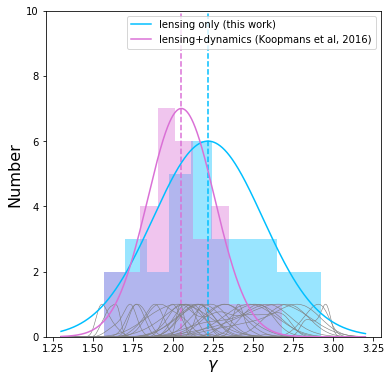

In [20]:
fig1, ax = plt.subplots(figsize=(6,6))
plt.axvline(x=mu_slopes_no_nan,ls="--", color="deepskyblue")
plt.axvline(x=mu_slopes_slacs_no_nan, ls="--", color="orchid")
for prob, info in zip(slope_probabilities_shear, info_shear):
    ax.plot(x, prob, color='gray', linewidth=0.6)
lensing, = plt.plot(x, y, color="deepskyblue",)
slacs, = plt.plot(x, y_slacs, color="orchid")
plt.legend([lensing, slacs], ["lensing only (this work) ", "lensing+dynamics (Koopmans et al, 2016)"],
                     loc="upper right")
plt.hist(slopes_shear_no_nan, 10, color="deepskyblue", alpha=0.4)   
plt.hist(slopes_slacs_no_nan, 10, color="orchid", alpha=0.4)   
plt.ylim(0,10)
plt.xlabel(r"$\gamma$", fontsize=16)
plt.ylabel("Number", fontsize=16)
plt.savefig(fig_path + 'slope_distributions_same_sample.png', bbox_inches='tight', dpi=300)

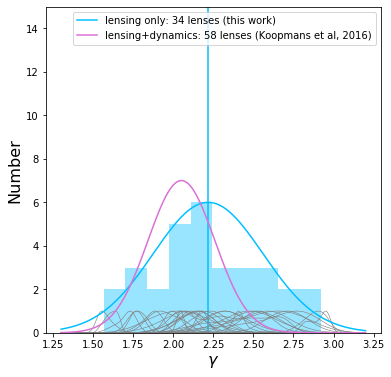

In [21]:
fig1, ax = plt.subplots(figsize=(6,6))
plt.axvline(x=mu_shear, color="deepskyblue")
for prob, info, data in zip(slope_probabilities_shear, info_shear,  agg_shear_cap.values("dataset")):
    ax.plot(x, prob, color='gray', linewidth=0.6)
lensing, = plt.plot(x, y, color="deepskyblue",)
slacs, = plt.plot(x, y_slacs, color="orchid")
plt.legend([lensing, slacs], ["lensing only: 34 lenses (this work) ", "lensing+dynamics: 58 lenses (Koopmans et al, 2016)"],
                     loc="upper right")
plt.hist(slopes_shear, 10, color="deepskyblue", alpha=0.4)   
plt.ylim(0,15)
plt.xlabel(r"$\gamma$", fontsize=16)
plt.ylabel("Number", fontsize=16)
plt.savefig(fig_path + 'slope_distributions_shear.png', bbox_inches='tight', dpi=300)

In [22]:
def velocity_dispersion_from(*, redshift_0, redshift_1, einstein_radius, cosmology):
    const = constants.c.to("kpc / s")
    angular_diameter_distance_to_redshift_0_kpc = angular_diameter_distance_to_earth_in_kpc_from(
        redshift=redshift_1,
        cosmology=cosmology
    )
    angular_diameter_distance_to_redshift_1_kpc = angular_diameter_distance_to_earth_in_kpc_from(
        redshift=redshift_1,
        cosmology=cosmology
    )
    angular_diameter_distance_between_redshifts_kpc = angular_diameter_distance_between_redshifts_in_kpc_from(
        redshift_0=redshift_0, redshift_1=redshift_1, cosmology=cosmology
    )
    kpc_per_arcsec = kpc_per_arcsec_from(redshift=redshift_0, cosmology=cosmology)
    einstein_radius_kpc = einstein_radius * kpc_per_arcsec
    velocity_dispersion_kpc = \
        const * np.sqrt(
            (einstein_radius_kpc * angular_diameter_distance_to_redshift_1_kpc) /
            (4 * np.pi * angular_diameter_distance_to_redshift_0_kpc * angular_diameter_distance_between_redshifts_kpc)
        )
    return velocity_dispersion_kpc.to("km/s").value

In [23]:

R_Ein = []
for instance in instances_shear:
    try:
        R_Ein.append(instance.galaxies.lens.einstein_radius_via_tangential_critical_curve)
    except TypeError:
        R_Ein.append(float("nan")) 

In [24]:
R_Ein_bells = []
for instance in instances_bells:
    try:
        R_Ein_bells.append(instance.galaxies.lens.einstein_radius_via_tangential_critical_curve)
    except TypeError:
        R_Ein_bells.append(float("nan")) 

NameError: name 'instances_bells' is not defined

In [ ]:
from astropy import constants
from astropy import units as u

sigma_SIE = []
sigma_frac = []


for info, instance, r in zip(info_shear, instances_shear, R_Ein):
    kpc_per_arcsec = cosmo.arcsec_per_kpc_proper(z=info["redshift_lens"]).value
    R_kpc = (r/kpc_per_arcsec)
    d_ls = cosmology_util.angular_diameter_distance_between_redshifts_in_kpc_from(
    redshift_0=info["redshift_lens"],
    redshift_1=info["redshift_source"],
    cosmology=cosmo)
    d_s = cosmology_util.angular_diameter_distance_to_earth_in_kpc_from(
    redshift=info["redshift_source"],
    cosmology=cosmo)
    d_l = cosmology_util.angular_diameter_distance_to_earth_in_kpc_from(
    redshift=info["redshift_lens"],
    cosmology=cosmo)
    sigma = ((constants.c.to("kpc/s")*np.sqrt(np.divide(R_kpc*d_s, 4*np.pi*d_ls*d_l)))*3.086e+16).value
    frac = info["sigma"]/sigma

    sigma_SIE.append(sigma)
    sigma_frac.append(frac)

In [ ]:
slopes_no_nan = []
std_slopes_no_nan = []
sigma_frac_no_nan = []
for i in  range(len(sigma_frac)):
    if math.isnan(sigma_frac[i]) == False:
        slopes_no_nan.append(slopes_shear[i])
        std_slopes_no_nan.append(std_slopes_shear[i])
        sigma_frac_no_nan.append(sigma_frac[i])

In [ ]:
print(len(slopes_no_nan))        
corr = stats.biweight_midcorrelation(sigma_frac_no_nan, slopes_no_nan)

print(corr)
bicov = stats.biweight_midcovariance([sigma_frac_no_nan, slopes_no_nan])
print(np.sqrt(bicov.diagonal())) 

In [ ]:
import scipy.optimize as opt

def func(x, m, c):
    return m*x+c

frac_fit = np.arange(0.5,1.3, 0.001)

fit, fit_cov = opt.curve_fit(func, sigma_frac_no_nan, slopes_no_nan, [0, 2], method='lm', sigma=std_slopes_no_nan)
uncert = np.sqrt(np.diag(fit_cov)) 

best_fit = func(frac_fit, fit[0], fit[1])
bound_upper = func(frac_fit, *(fit + uncert))
bound_lower = func(frac_fit, *(fit - uncert))

print(fit,uncert)

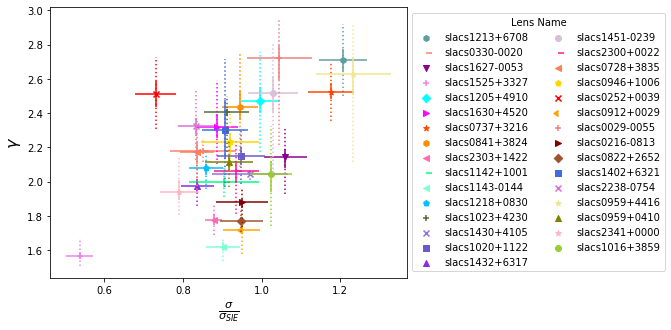

In [155]:
fig1, ax = plt.subplots(figsize=(8,5))
for i, samps, info, instance, dataset, err in zip(
        range(len(sigma_frac)),
        agg_shear_cap.values("samples"),
        info_shear, instances_shear,
        agg_shear_cap.values("dataset"),
        percent_error):
    if math.isnan(sigma_frac[i])==False: 
        ax.scatter(sigma_frac[i], instance.galaxies.lens.mass.slope, color=info["colour"], marker=info["marker"],
                   label=dataset.name)
        ax.errorbar(sigma_frac[i], instance.galaxies.lens.mass.slope,
                     yerr=[[samps.error_vector_at_lower_sigma(sigma=1.0)[7]], [samps.error_vector_at_upper_sigma(sigma=1.0)[7]]],
                      xerr=err, color=info["colour"])
        error_2 = ax.errorbar(sigma_frac[i], instance.galaxies.lens.mass.slope,
                     yerr=[[samps.error_vector_at_lower_sigma(sigma=2.0)[7]], [samps.error_vector_at_upper_sigma(sigma=2.0)[7]]],
                     color=info["colour"])
        error_2[-1][0].set_linestyle('dotted')
    else:
        pass
plt.xlabel(r"$\frac{\sigma}{\sigma_{SIE}}$", fontsize=16)
plt.ylabel(r"$\gamma$", fontsize=16)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
plt.savefig(fig_path + 'shear_slope_v_sigma_frac.png', bbox_inches='tight', dpi=300)  

In [131]:
percent_error = [info["sigma_err"]/info["sigma"]*sigma for info, sigma in zip(info_shear, sigma_frac)]

In [133]:
print(percent_error)

[nan, 0.06197882579722588, 0.08430305961631798, nan, 0.05485787147406823, 0.03403801814933107, nan, 0.04966736634490132, 0.05146303682739851, 0.05915963952284567, 0.04616301215931386, 0.02065172025230543, 0.09003514211029216, 0.04360112799830577, 0.04313017164479961, 0.056448530582752746, 0.0963819527689392, 0.06047872664452625, 0.04200044336912382, 0.06459589593216311, 0.05697422284039987, 0.042955082959752255, 0.07343227436596188, 0.05154656023875513, 0.0465738696826835, 0.08215074205878467, 0.0654574777202643, 0.054917549287595284, 0.057728615908096595, 0.04630112618096552, 0.09601594696643143, 0.060469851900497675, 0.04964146081197799, 0.053920395948611886, nan, nan]
